In [1]:
import pandas as pd
from utils_clean import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
dtypes={'tourney_id': str,
        'draw_size': str,
        'winner_id': 'Int64',
        'loser_id': 'Int64',
        'winner_seed':  str,
        'winner_entry': str,
        'loser_entry': str,
        'loser_seed':  str,
       }

dtypes={**dtypes,**{'W'+str(i+1):'Int64' for i in range(5)},**{'L'+str(i+1):'Int64' for i in range(5)}}
df=pd.read_csv('csvs/atp_matches.csv',dtype=dtypes, date_format='%Y%m%d',parse_dates=['tourney_date'])
df['tourney_date']=pd.to_datetime(df.tourney_date, format = '%Y-%m-%d')

## Quick analysis on the average number of minutes over time

In [4]:
t=df.sort_values(by=['tourney_date','tourney_id','match_num'])
t.set_index('tourney_date', inplace=True)

In [5]:
t=t.loc[~t.minutes.isna()]

<Axes: xlabel='tourney_date'>

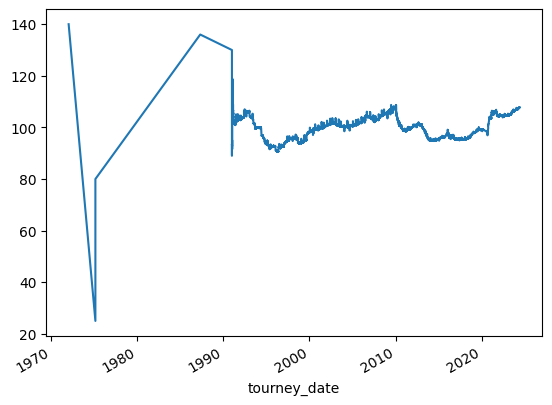

In [6]:
t.minutes.rolling('365D').mean().plot()

<Axes: xlabel='tourney_date'>

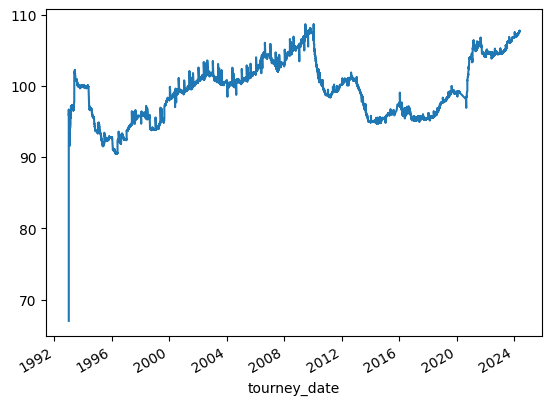

In [7]:
t=t.loc[t.index>'1993-01-01']
t.minutes.rolling('365D').mean().plot()

Not entirely convincing

## Filter 

Looking at some of the minutes of the matches are suspicious for example, the 1st round match of Bevker v Reneberg at the 1993 USO lasted 25 minutes yet was seemingly a five set match including a tiebreaker. This issue seems to stem from the source, i.e the ATP website, where if you look at the 1993 USO, there are a lot of suspicious times. This issue seems to exist even as late as 1996. However not all match times seem to be erroneous, for example at the 1996 USO Hlasek v Gumy seems to be accurately listed as a 1 hour 32 minute match and yet Edberg v Haarhuis was only a 2 minute match. We can begin by filtering out matches less than 10 minutes as it's safe to say these are either walkover.

We will proceed in a quite crude fashion, namely insisting that for every set played at least 12 minutes has elapsed (from the fact that the shortest ATP match was a 6-0 6-0 victory with 25 minutes elapsed), and that at most 140 minutes elapsed each set for 5-setters and 90 minutes for 3-setters (both derived from the records on BO5 and BO3 contests). From there we will generate two data-sets, one where the incorrect is correctly by insisting the time is the number of sets times the avg time per set, obviously this approach would skew the old data as older data are more likley to be corrupted. Alternative we simply remove the points that are suspicious. 

In [8]:
df['n_set']=df.apply(n_set,axis=1)

In [9]:
df['n_set'].describe()

count    409767.000000
mean          2.447283
std           0.686140
min           0.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           5.000000
Name: n_set, dtype: float64

In [10]:
df1=df.loc[(12*df.n_set<=df.minutes),:]
#Beware this set removes nan and walkovers, ret and etc.

In [11]:
df1=df1.loc[df1.apply(filter_high,axis=1),:]

<Axes: xlabel='tourney_date'>

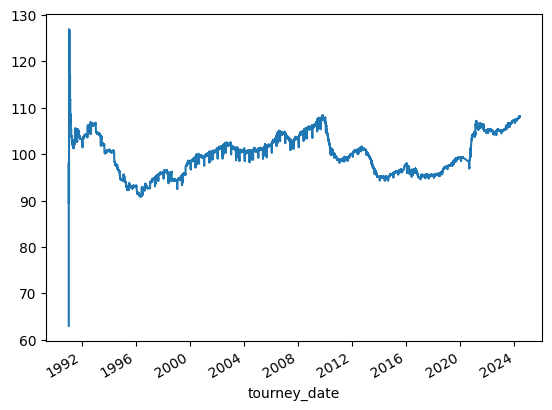

In [12]:
t1=df1.sort_values(by=['tourney_date','tourney_id','match_num'])
t1.set_index('tourney_date', inplace=True)
t1=t1.loc[t1.index>'1991-01-01']
t1.minutes.rolling('360D').mean().plot()

Hard to say if the average match duration has gone up over the years, despite the widely accepted belief that it has. Numerous explanations exist for this, including introducing various rules and scoring formats to shorten matches. Beyond that it's also possible that the data is biased in the sense a larger proportion of the ATP Tour is played in BO3 compared to before when Masters finals used to be BO5.

<Axes: xlabel='tourney_date'>

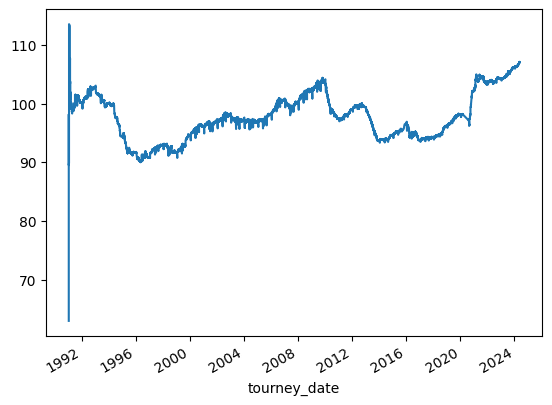

In [13]:
t1.loc[t1.n_set<5].minutes.rolling('360D').mean().plot()

<Axes: xlabel='tourney_date'>

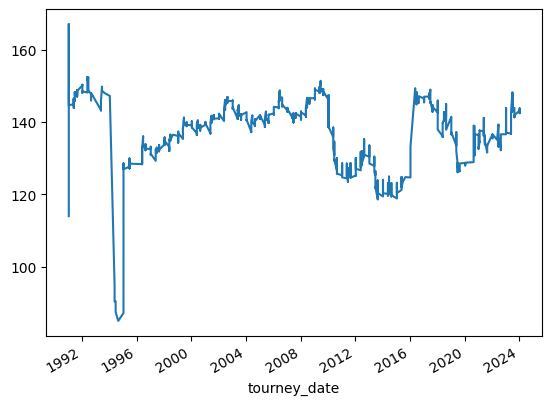

In [14]:
t1.loc[t1.tourney_level=='Grand Slam'].minutes.rolling('360D').mean().plot()

<Axes: xlabel='tourney_date'>

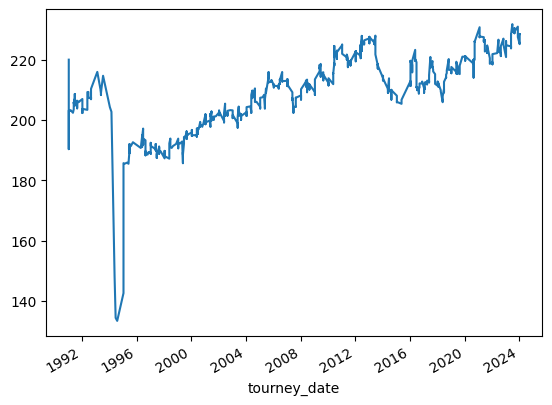

In [15]:
t1.loc[t1.n_set==5].minutes.rolling('360D').mean().plot()

Interestingly the data on matches that have gone 5 sets is the most conclusive so far.

<Axes: xlabel='tourney_date'>

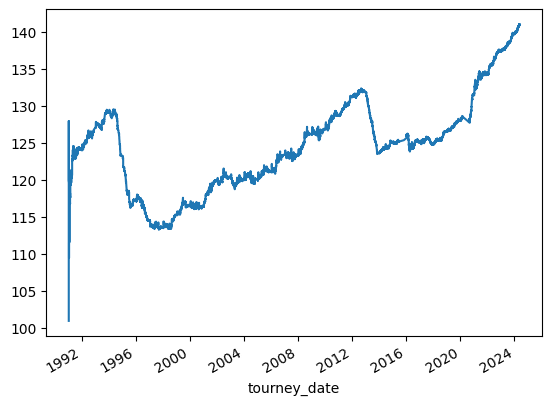

In [16]:
t1.loc[t1.n_set==3].minutes.rolling('360D').mean().plot()

<Axes: xlabel='tourney_date'>

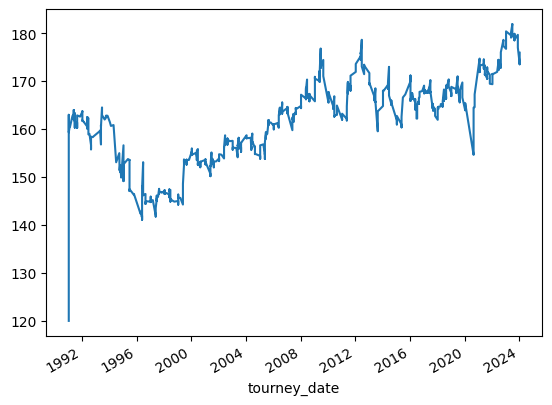

In [17]:
t1.loc[t1.n_set==4].minutes.rolling('360D').mean().plot()

<Axes: xlabel='tourney_date'>

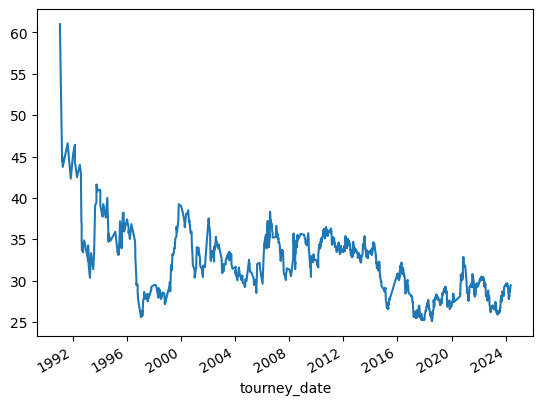

In [18]:
t1.loc[t1.n_set==1].minutes.rolling('360D').mean().plot()

<Axes: xlabel='tourney_date'>

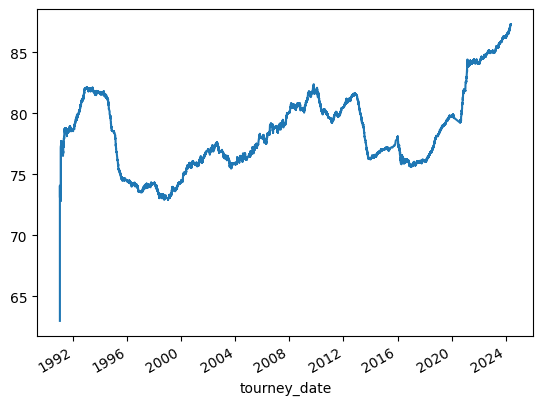

In [19]:
t1.loc[t1.n_set==2].minutes.rolling('360D').mean().plot()

It seems shorter matches have become shorter, but longer matches have gotten longer.

## Clean
Same as section on filter but actually replacing instead of removing. This is relevant for tasks such as trying to gauge how much time a player play during tournament.
The choice of replacement obviously matters here, as careless can easily result in biases

In [20]:
df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'retirement', 'W1', 'W2', 'W3', 'W4', 'W5', 'L1', 'L2', 'L3', 'L4',
       'L5', 'n_set'],
      dtype='object')

As observed before, the data on match time is vastly inconsistent before 1992 so we will proceed with data gathered after 1992:

In [21]:
dfx=df.loc[df.tourney_date>'1991-12-31',:]
dfx.loc[:,'minutes']=dfx.minutes.fillna(0)
dfx.loc[:,'minutes']=dfx.apply(repair_min,axis=1)

In [22]:
set_time=dfx.minutes/dfx.n_set

In [23]:
set_time[dfx.n_set>0].mean()

np.float64(39.93183681180831)

We see there is a slight bias here, in other words the way data is cleaned could still be improved.

In [24]:
a,b=cum_min_w(dfx)

In [25]:
df1=pd.concat(a)
df2=pd.concat(b)

In [26]:
dfx.shape

(295043, 61)

In [27]:
df2=df2.drop('loser_id',axis=1)

In [28]:
t=pd.merge(left=dfx,right=df1,how='left',left_on=['tourney_id', 'loser_id'],right_on=['tourney_id', 'loser_id'])
t=t.drop_duplicates()

In [29]:
f=pd.merge(left=t,right=df2,how='left',left_on=['tourney_id', 'winner_id','match_num'],right_on=['tourney_id', 'winner_id','match_num'])
f=f.drop_duplicates()

In [30]:
f

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,W4,W5,L1,L2,L3,L4,L5,n_set,l_min,w_min
0,1992-301,Auckland,Hard,32,A,1992-01-06,1,101797,NaN,NaN,...,<NA>,<NA>,6,6,<NA>,<NA>,<NA>,2.0,NaN,0.0
1,1992-301,Auckland,Hard,32,A,1992-01-06,2,101205,NaN,NaN,...,<NA>,<NA>,3,4,<NA>,<NA>,<NA>,2.0,NaN,0.0
2,1992-301,Auckland,Hard,32,A,1992-01-06,3,101368,NaN,NaN,...,<NA>,<NA>,4,2,<NA>,<NA>,<NA>,2.0,NaN,0.0
3,1992-301,Auckland,Hard,32,A,1992-01-06,4,100772,NaN,WC,...,<NA>,<NA>,6,5,<NA>,<NA>,<NA>,2.0,NaN,0.0
4,1992-301,Auckland,Hard,32,A,1992-01-06,5,101532,4.0,NaN,...,<NA>,<NA>,4,6,3,<NA>,<NA>,3.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295042,2024-8266,Augsburg CH,Clay,32,Challenger,2024-05-20,296,109054,NaN,NaN,...,<NA>,<NA>,3,2,<NA>,<NA>,<NA>,2.0,252.0,250.0
295043,2024-8266,Augsburg CH,Clay,32,Challenger,2024-05-20,297,207608,1,NaN,...,<NA>,<NA>,6,4,<NA>,<NA>,<NA>,2.0,226.0,223.0
295044,2024-8266,Augsburg CH,Clay,32,Challenger,2024-05-20,298,209284,8,NaN,...,<NA>,<NA>,6,2,5,<NA>,<NA>,3.0,277.0,350.0
295045,2024-8266,Augsburg CH,Clay,32,Challenger,2024-05-20,299,207608,1,NaN,...,<NA>,<NA>,5,5,<NA>,<NA>,<NA>,2.0,325.0,325.0


In [31]:
f.to_csv('csvs/atp_matches_time.csv', index=False)